In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# Import DataFrames

In [8]:
full_data = pd.read_csv("./datasets/application_record.csv")
credit_data = pd.read_csv("./datasets/credit_record.csv")

In [9]:
full_data

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0


In [10]:
credit_data

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
...,...,...,...
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C


In [11]:
begin_month = pd.DataFrame(credit_data.groupby("MONTHS_BALANCE").agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'Account age'})

credit_full_data = pd.merge(begin_month, full_data, how="right", on="ID")

credit_data["dep_value"] = None
credit_data['dep_value'][credit_data['STATUS'] =='2']='Yes'
credit_data['dep_value'][credit_data['STATUS'] =='3']='Yes'
credit_data['dep_value'][credit_data['STATUS'] =='4']='Yes'
credit_data['dep_value'][credit_data['STATUS'] =='5']='Yes'
cpunt = credit_data.groupby('ID').count()
cpunt = cpunt[['dep_value']]

credit_full_data = pd.merge(credit_full_data, cpunt, how = 'inner', on = 'ID')
credit_full_data["Is high risk"] = credit_full_data['dep_value']    #Chỉ số đánh giá tín dụng

credit_full_data.loc[credit_full_data["Is high risk"] == 'Yes', 'Is high risk'] = 1
credit_full_data.loc[credit_full_data["Is high risk"] == 'No', 'Is high risk'] = 0
credit_full_data.drop('dep_value',axis=1)


C:\Users\Minh\AppData\Local\Temp\ipykernel_1888\2372148486.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_data['dep_value'][credit_data['STATUS'] =='2']='Yes'
C:\Users\Minh\AppData\Local\Temp\ipykernel_1888\2372148486.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_data['dep_value'][credit_data['STATUS'] =='3']='Yes'
C:\Users\Minh\AppData\Local\Temp\ipykernel_1888\2372148486.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

,ID,STATUS,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Is high risk
0,5008804,NaN,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
1,5008805,NaN,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
2,5008806,NaN,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0
3,5008808,NaN,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
4,5008809,NaN,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,NaN,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348,-2420,1,0,0,0,Managers,2.0,4
36453,5149834,NaN,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,11
36454,5149838,NaN,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,11
36455,5150049,NaN,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,Sales staff,2.0,1


### Reaname featrures

In [12]:
credit_full_data = credit_full_data.rename(columns={
    'CODE_GENDER':'Gender',
    'FLAG_OWN_CAR':'Has a car',
    'FLAG_OWN_REALTY':'Has a property',
    'CNT_CHILDREN':'Children count',
    'AMT_INCOME_TOTAL':'Income',
    'NAME_INCOME_TYPE':'Employment status',
    'NAME_EDUCATION_TYPE':'Education level',
    'NAME_FAMILY_STATUS':'Marital status',
    'NAME_HOUSING_TYPE':'Dwelling',
    'DAYS_BIRTH':'Age',
    'DAYS_EMPLOYED': 'Employment length',
    'FLAG_MOBIL': 'Has a mobile phone',
    'FLAG_WORK_PHONE': 'Has a work phone',
    'FLAG_PHONE': 'Has a phone',
    'FLAG_EMAIL': 'Has an email',
    'OCCUPATION_TYPE': 'Job title',
    'CNT_FAM_MEMBERS': 'Family member count',
    'Account age': 'Account age'
})

### Split data to training, testing and creating data

In [13]:
def data_split(df, testsize):
    train_df, test_df = train_test_split(df, test_size=testsize, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [14]:
train_original, test_original = data_split(credit_full_data, 0.2)

In [15]:
train_original.shape

(29165, 21)

In [16]:
test_original.shape

(7292, 21)

In [17]:
train_original.to_csv("train.csv", index= False)
test_original.to_csv("test.csv", index= False)

In [18]:
train_copy = train_original.copy()
test_copy = test_original.copy()

### 2. Funtction used each features

In [19]:
#Funcction trar về giá trị và tần số tương ứng của chúng
def value_count_norm_call(df, feature):
    frt_value_count = df[feature].value_counts()
    frt_value_count_norm = df[feature].value_counts(normalize=True)
    frt_value_concat = pd.concat([frt_value_count, frt_value_count_norm], axis = 1)
    frt_value_concat.columns = ['Count', 'Frequency (%)']
    return frt_value_concat

In [20]:
def get_info(df, feature):
    if feature == 'Age':
            print('Description:\n{}'.format((np.abs(df[feature])/365).describe()))
            print('*'*50)
            print('Object type:{}'.format(df[feature].dtype))
    elif feature== 'Employment length':
            # select only the rows where the rows are negative to ignore whose who have retired or unemployed
            employment_len_no_ret = train_copy['Employment length'][train_copy['Employment length'] < 0]
            employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365
            print('Description:\n{}'.format((employment_len_no_ret_yrs).describe()))
            print('*'*50)
            print('Object type:{}'.format(employment_len_no_ret.dtype))
    elif feature =='Account age':
            # change the account age to a positive number of months
            print('Description:\n{}'.format((np.abs(df[feature])).describe()))
            print('*'*50)
            print('Object type:{}'.format(df[feature].dtype))
    else:
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Object type:\n{}'.format(df[feature].dtype))
            value_cnt = value_count_norm_call(df,feature)
            print('Value count:\n{}'.format(value_cnt))

In [21]:
# Function tạo biểu đồ hình tròn
def creat_pie_plot(df, feature):
    if feature == 'Drewlling' or 'Education':
        ratio_size = value_count_norm_call(df, feature)
        ratio_size_len = len(ratio_size.index)
        ratio_list = []
        for i in range(ratio_size_len):
            ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
        fig, ax = plt.subplots(figsize=(8,8))
        # %1.2f%% display decimals in the pie chart with 2 decimal places
        plt.pie(ratio_list, startangle=90, wedgeprops={'edgecolor' :'black'})
        plt.title('Pie chart of {}'.format(feature))
        plt.legend(loc='best',labels=ratio_size.index)
        plt.axis('equal')
        return plt.show()
    else :
        ratio_size = value_count_norm_call(df, feature)
        ratio_size_len = len(ratio_size.index)
        ratio_list = []
        for i in range(ratio_size_len):
            ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
        fig, ax = plt.subplots(figsize=(8,8))
        # %1.2f%% display decimals in the pie chart with 2 decimal places
        plt.pie(ratio_list, labels=ratio_size.index, autopct='%1.2f%%', startangle=90, wedgeprops={'edgecolor' :'black'})
        plt.title('Pie chart of {}'.format(feature))
        plt.legend(loc='best')
        plt.axis('equal')
        return plt.show()

In [22]:
#function để tạo ra các bar chart
def creat_bar_chart(df, feature):
    if feature == 'Marital status' or 'Dwelling' or 'Job title'or 'Employment status' or 'Education level':
        fig, ax = plt.subplots(figsize=(6,10))
        sns.barplot(x=value_count_norm_call(df,feature).index,y=value_count_norm_call(df,feature).values[:,0])
        ax.set_xticklabels(labels=value_count_norm_call(df,feature).index,rotation=45,ha='right')
        plt.xlabel('{}'.format(feature))
        plt.ylabel('Count')
        plt.title('{} count'.format(feature))
        return plt.show()
    if feature == _:
        fig, ax = plt.subplots(figsize=(6,10))
        sns.barplot(x=value_count_norm_call(df,feature).index,y=value_count_norm_call(df,feature).values[:,0])
        plt.xlabel('{}'.format(feature))
        plt.ylabel('Count')
        plt.title('{} count'.format(feature))
        return plt.show()

In [23]:
#Function để tạo bar chart
def creat_bar_plot(df, feature):
    if feature == 'Marital status' or 'Dwelling' or 'Job title' or 'Employment status' or 'Education level':
        fig, ax = plt.subplots(figsize =(6, 10))
        sns.barplot(x = value_count_norm_call(df, feature).index, y = value_count_norm_call(df, feature).values[:, 0])
        ax.set_xticklabels(label= value_count_norm_call(df, feature).index, rotation=45, ha= 'right')
        plt.xlabel('{}'.format(feature))
        plt.ylabel('Count')
        plt.title('{}count'.format(feature))
        return plt.show()
    else:
        fig, ax = plt.subplots(figsize=(6,10))
        sns.barplot(x=value_count_norm_call(df,feature).index,y=value_count_norm_call(df,feature).values[:,0])
        plt.xlabel('{}'.format(feature))
        plt.ylabel('Count')
        plt.title('{} count'.format(feature))
        return plt.show()

In [24]:
#Function tạo box plot
def creat_box_plot(df, feature):
    if feature == 'Age':
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y = np.abs(df[feature]/365))
        plt.title('{} distribution(Boxplot)'.format(feature))
        return plt.show()
    if feature == 'Children count':
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=df[feature])
        plt.title('{} distribution(Boxplot)'.format(feature))
        plt.yticks(np.arange(0,df[feature].max(),1))
        return plt.show()
    if feature == 'Employment length':
        fig, ax = plt.subplots(figsize=(2,8))
        employment_len_no_ret = train_copy['Employment length'][train_copy['Employment length'] < 0]
        # employement length in days is a negative number so we need to change it to positive and change it to days
        employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
        sns.boxplot(y=employment_len_no_ret_yrs)
        plt.title('{} distribution(Boxplot)'.format(feature))
        plt.yticks(np.arange(0,employment_len_no_ret_yrs.max(),2))
        return plt.show()
    if feature == 'Account age':
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=np.abs(df[feature]))
        plt.title('{} distribution(Boxplot)'.format(feature))
        return plt.show()
        

In [25]:
def creat_hist_plot(df, feature, thebins=50):
    if feature == 'Age':
        fig, ax = plt.subplots(figsize= (18,10))
        sns.histplot(np.abs(df[feature]/365.25),bins= thebins)
        plt.title("{}distribution".format(feature))
        return plt.show()
    if feature == 'Income':
        fig, ax = plt.subplots(figsize=(18, 10))
        sns.histplot(df[feature], bins= thebins)
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x),"," )))
        plt.title('{} distribution'.format(feature))
        return plt.show()
    if feature == 'Account age':
        fig, ax = plt.subplots(18,10)
        sns.histplot(np.abs(df[feature], bins= thebins))
        plt.title("{}distribution".format(feature))
        return plt.show()
    if feature == _:
        fig, ax = plt.subplots(18,10)
        sns.histplot(df[feature], bins= thebins)
        plt.title("{}distribution".format(feature))
        return plt.show()

# Phân tích đơn biến

## Gender

In [26]:
get_info(train_copy, "Gender")

Description:
count     29165
unique        2
top           F
freq      19549
Name: Gender, dtype: object
**************************************************
Object type:
object
Value count:
   Count  Frequency (%)
F  19549        0.67029
M   9616        0.32971


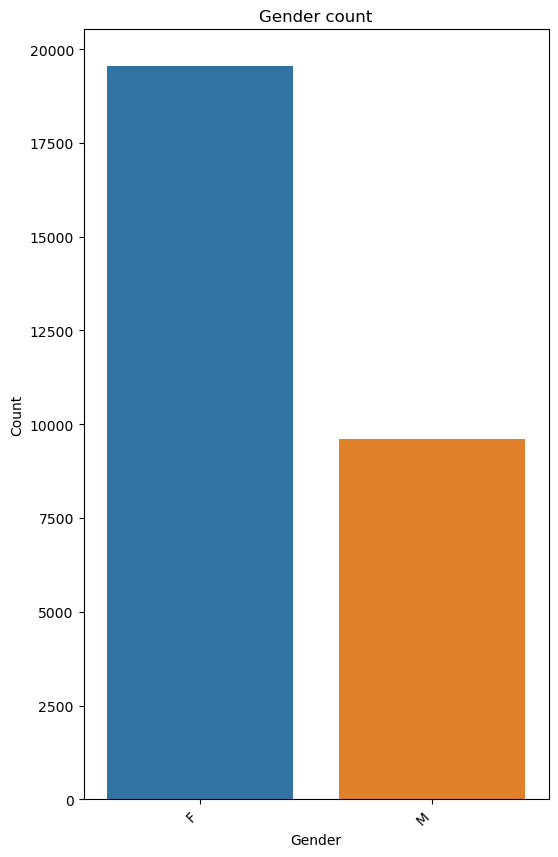

In [27]:
creat_bar_chart(train_copy, "Gender")

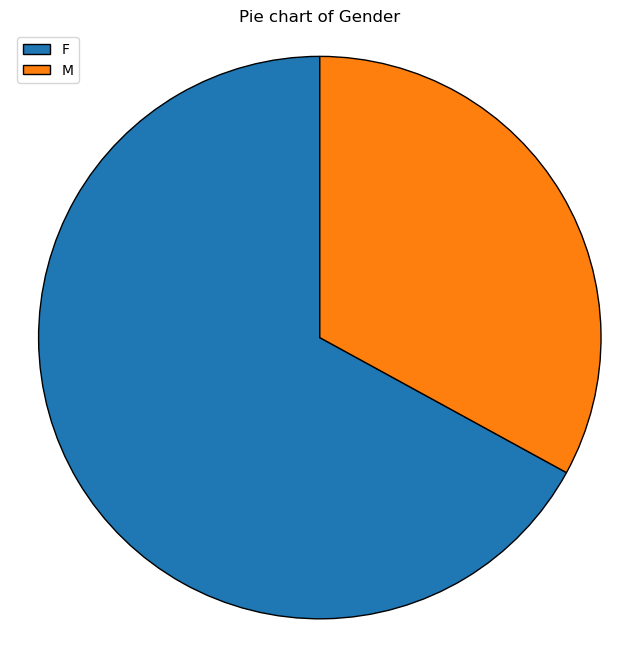

In [28]:
creat_pie_plot(train_copy, 'Gender')

## Age

In [29]:
get_info(train_copy, 'Age')

Description:
count    29165.000000
mean        43.779390
std         11.515062
min         21.109589
25%         34.178082
50%         42.643836
75%         53.271233
max         68.909589
Name: Age, dtype: float64
**************************************************
Object type:int64


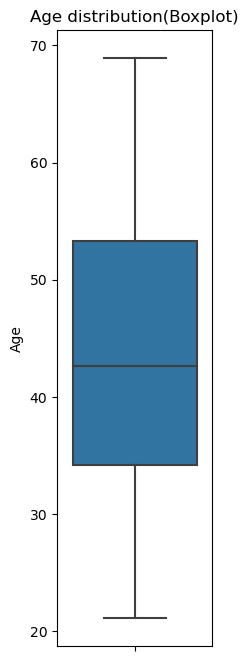

In [30]:
creat_box_plot(train_copy, 'Age')

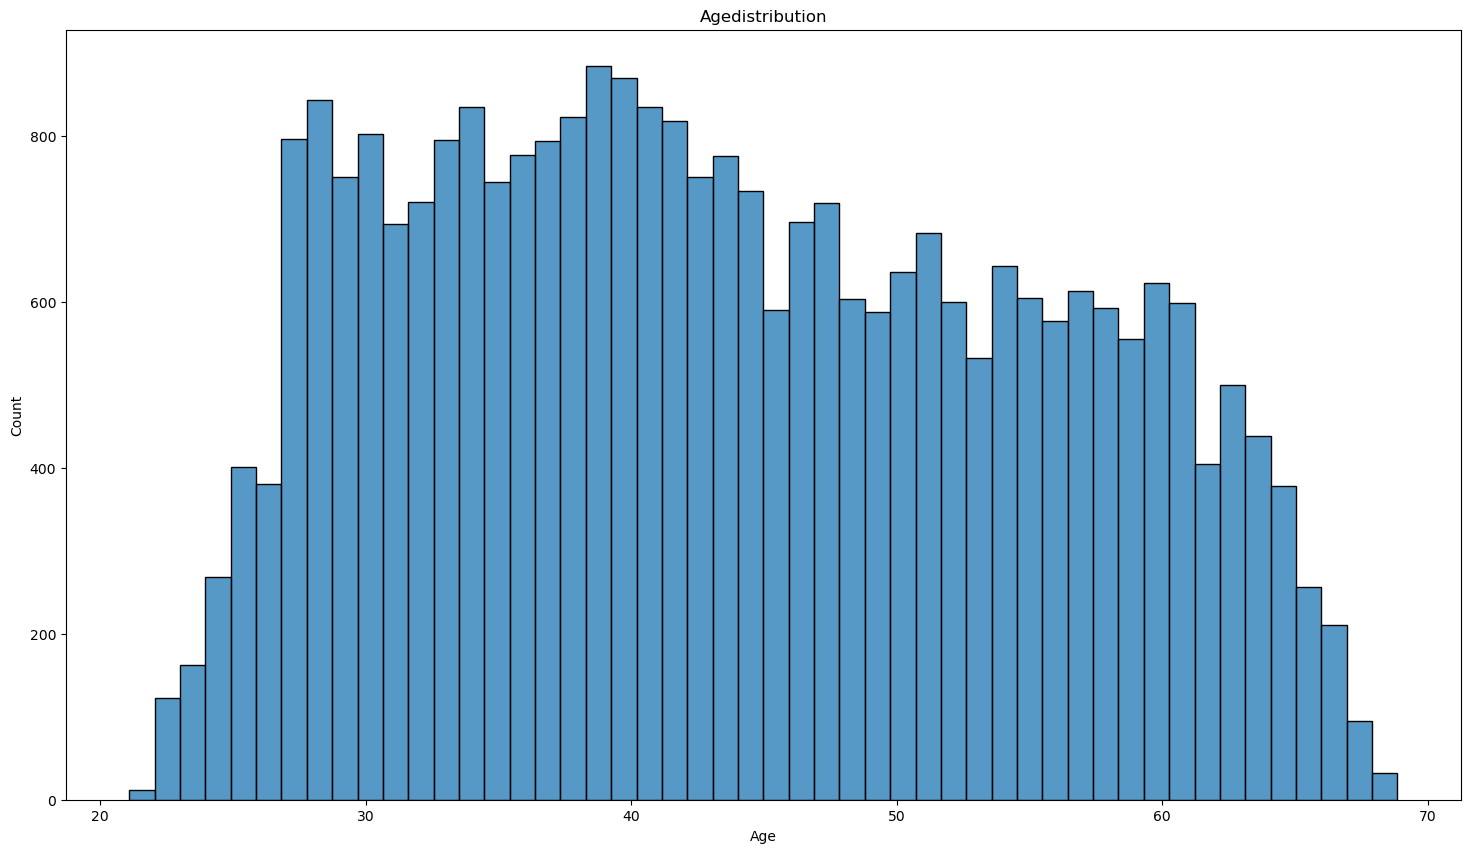

In [31]:
creat_hist_plot(train_copy, 'Age')